## Semantic Segmentation for Grid Detection
Can we use a semseg model to find out where the futoshiki grid is an a given image?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp
import torch
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import functools

In [4]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'GeForce RTX 2070 SUPER')

In [5]:
data_path = 'data/box_segmentation'

x_all_train_path = os.path.join(data_path, 'all_train')
x_train_path = os.path.join(data_path, 'train')
x_valid_path = os.path.join(data_path, 'validation')
x_test_path = os.path.join(data_path, 'test')

y_train_path = os.path.join(data_path, 'labels', 'train.csv')
y_valid_path = os.path.join(data_path, 'labels', 'valid.csv')
y_test_path = os.path.join(data_path, 'labels', 'test.csv')

Split all training data into train and validation sets

In [12]:
# labels_path = os.path.join(data_path, 'labels')
# files = ['train.csv', 'train_2.csv', 'train_3.csv']

# all_data = pd.concat([pd.read_csv(os.path.join(labels_path, f)) for f in files])

# all_data.to_csv(os.path.join(labels_path, 'all_train.csv'), index=False)
# all_train = pd.read_csv(os.path.join(labels_path, 'all_train.csv'))

# # split image masks
# train = all_train.sample(frac=0.75, replace=False, random_state=42)
# validation = all_train[~all_train['filename'].isin(train['filename'])]

# train.to_csv(y_train_path, index=False)
# validation.to_csv(y_valid_path, index=False)

# # split images
# all_train_files = os.listdir(x_all_train_path)
# train_files = [x for x in all_train_files if x in train['filename'].tolist()]
# validation_files = [x for x in all_train_files if x in validation['filename'].tolist()]

# _ = [shutil.copyfile(os.path.join(x_all_train_path, x), os.path.join(x_train_path, x)) for x in train_files]
# _ = [shutil.copyfile(os.path.join(x_all_train_path, x), os.path.join(x_valid_path, x)) for x in validation_files]

In [6]:
def image_transpose_exif(im: np.array) -> np.array:
    """Transpose smartphone images that mave be incorrectly oriented.

    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

In [7]:
class FutoshikiGridDataset(Dataset):
    """Futoshiki Grid dataset."""

    def __init__(self, csv_file, root_dir, resize=None, transform=None, augmentation=None, copies=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.grid_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.resize = resize
        self.transform = transform
        self.augmentation = augmentation
        self.copies = copies

    def __len__(self):
        if self.copies:
            return self.grid_frame.shape[0] * self.copies
        else:
            return self.grid_frame.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.copies:
            idx = idx % self.grid_frame.shape[0]

        img_name = os.path.join(self.root_dir,
                                self.grid_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image_transpose_exif(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        shape = image.shape
                
        grid = self.grid_frame.loc[idx, 'region_shape_attributes']
        mask = get_mask(grid, shape[:2])
        mask = mask / 255 # normalise
        # mask = np.stack(masks, axis=-1).astype('float')
        
        if self.resize is not None:
            image, mask = cv2.resize(image, (320, 480)), cv2.resize(mask, (320, 480))
            mask = mask.reshape((*mask.shape, 1))
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

def get_mask(row, shape):
    row = json.loads(row)
    coords = np.array([[x,y] for x, y in zip(row['all_points_x'], row['all_points_y'])])
    mask = np.zeros((*shape, 1))
    cv2.fillPoly(mask, [coords], 255)
    return mask

In [8]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color='white')
        plt.imshow(image)
    plt.show()

In [9]:
os.chdir('..')

In [10]:
os.getcwd()

'/home/sam/projects/personal/futoshiki-solver'

In [11]:
y_train_path

'data/box_segmentation/labels/train.csv'

In [12]:
grid_dataset = FutoshikiGridDataset(y_train_path, x_train_path, 0.25, copies=2)
len(grid_dataset)

86

### Look at base images and masks

In [13]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 100

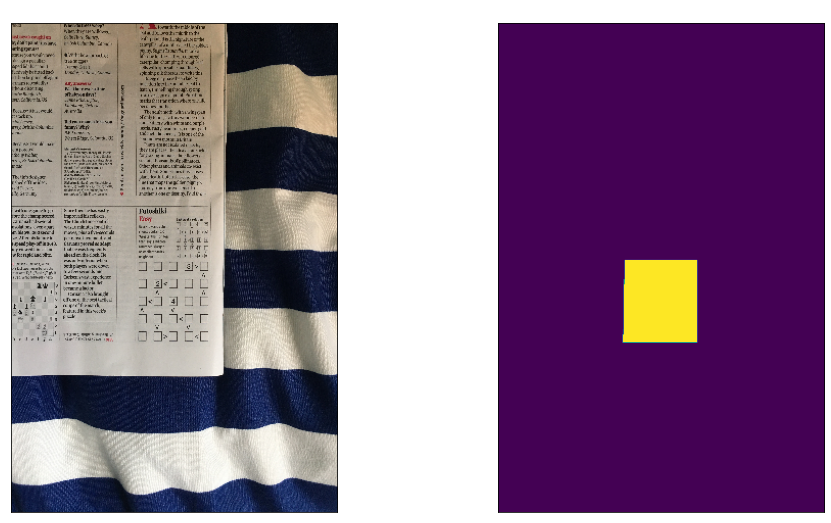

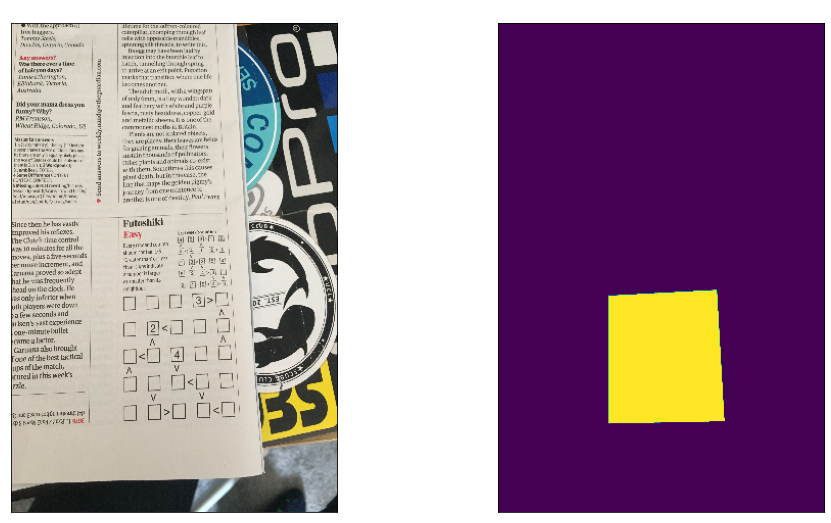

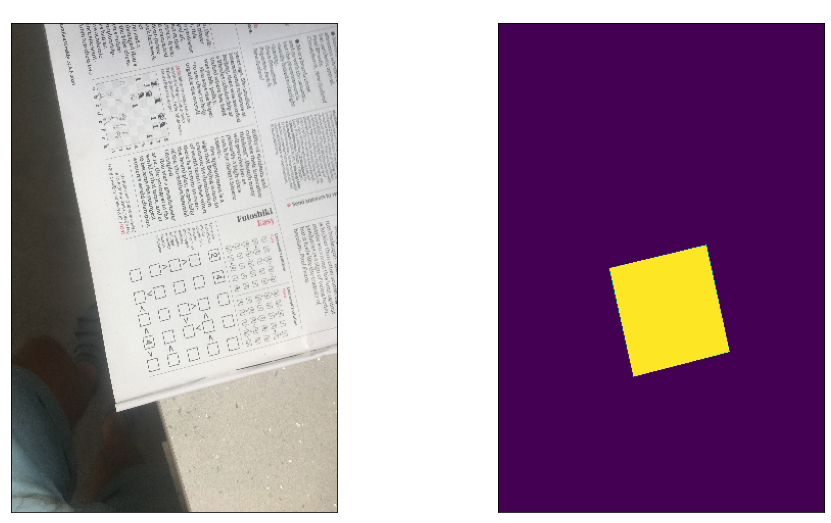

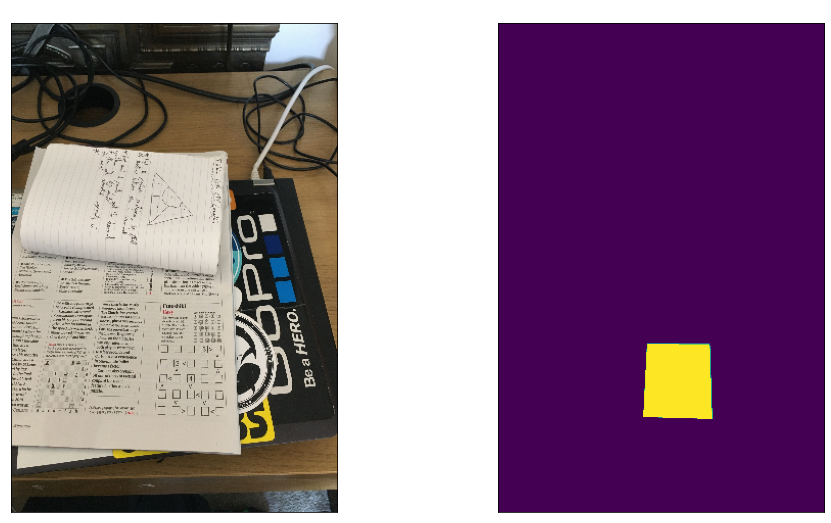

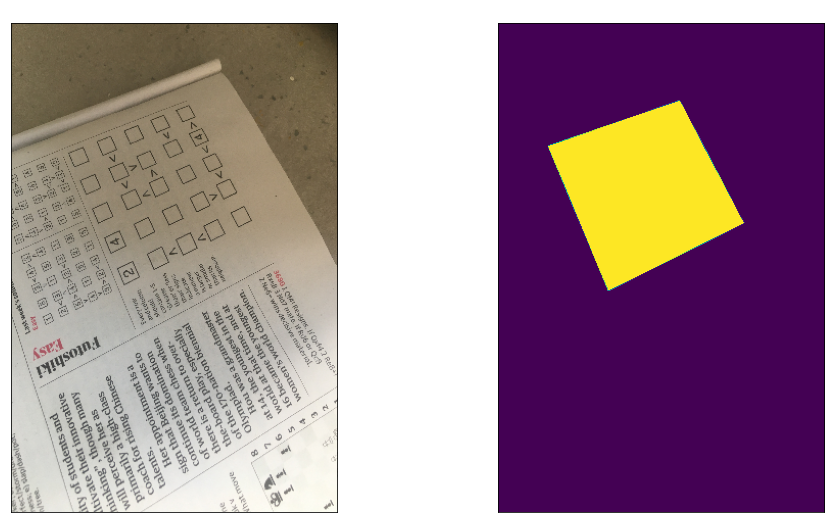

In [14]:
grid_dataset = FutoshikiGridDataset(y_train_path, x_train_path, True)

for x in range(5):
    out = grid_dataset[x]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

### Data Augmentation

In [15]:
import albumentations as albu

In [16]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.8, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.1),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

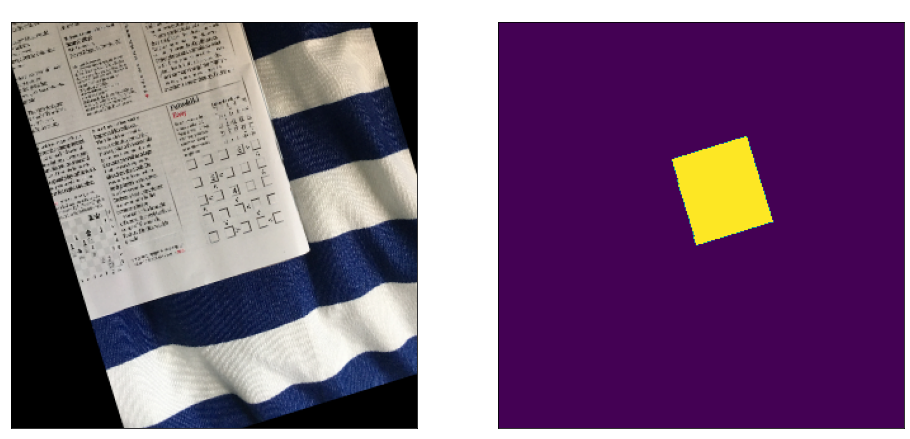

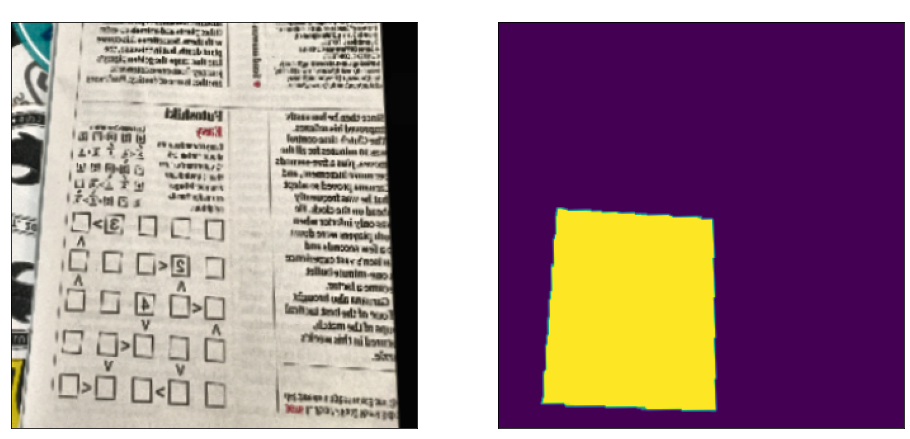

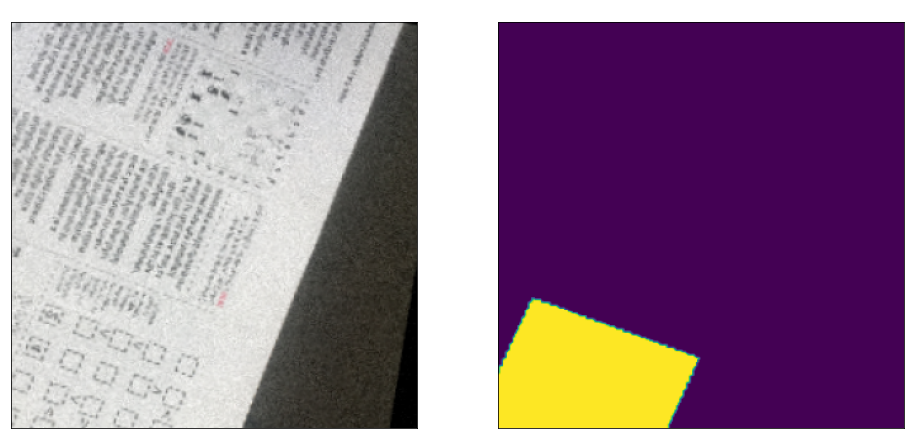

In [17]:
augmented_dataset = FutoshikiGridDataset(
    y_train_path, x_train_path, resize=True,
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze())

In [18]:
import gc; gc.collect()

10705

In [19]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['grid']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device('cuda:0')

In [20]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
).to('cuda')

In [21]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [22]:
train_dataset = FutoshikiGridDataset(y_train_path, x_train_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_training_augmentation(), copies=2)
print('Number of training samples:', len(train_dataset))

valid_dataset = FutoshikiGridDataset(y_valid_path, x_valid_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_validation_augmentation(), copies=1)

Number of training samples: 86


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

In [24]:
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.CrossEntropyLoss()
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
# max_score = 0

# for i in range(0, 40):
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './best_model_3.pth')
#         print('Model saved!')
        
#     if i == 15:
#         new_lr = 5e-5
#         optimizer.param_groups[0]['lr'] = new_lr
#         print(f'Decrease decoder learning rate to {new_lr}!')

In [27]:
model = torch.load('./best_model_2.pth').to('cuda')

### Visualise test predictions

In [28]:
test_dataset = FutoshikiGridDataset(
    y_test_path, x_test_path, resize=True,
    augmentation=get_validation_augmentation(), 
    transform=get_preprocessing(preprocessing_fn),
    copies=1
)

test_dataloader = DataLoader(test_dataset)

In [29]:
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s, dice_loss - 0.04462, iou_score - 0.952] 


In [30]:
# test dataset without transformations for image visualization
test_dataset_vis = FutoshikiGridDataset(
    y_test_path, x_test_path, # resize=True 
)

In [31]:
model_cpu = model.to('cpu')

In [33]:
# time one prediction
%time
torch.no_grad()
image_vis = test_dataset_vis[i][0].astype('uint8')
image, gt_mask = test_dataset[i]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).unsqueeze(0)
pr_mask = model_cpu.predict(x_tensor)
pr_mask = pr_mask.squeeze().numpy().round()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [82]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate(input_sample):
    num_frames = input_sample.shape[0]
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(input_sample[0,:,:,:])

    def update(i):
        img = input_sample[i,:,:,:]
        im.set_data(img)
        return im

    ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False, interval=60)  
    return ani


In [90]:
# TODO find a way to get the frame rate of the video and calculate the required interval between frames
# TODO scale up to full sized images
vidcap = cv2.VideoCapture('data/box_segmentation/video/IMG_3201.MOV')
frames_processed = []
success, image_base = vidcap.read()
val_aug = get_validation_augmentation()
count = 0 

while success:    
    image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
    image_base = cv2.rotate(image_base, cv2.ROTATE_90_CLOCKWISE)
    
    image = cv2.resize(image_base, (320, 480))
    frame = val_aug(image=image)['image']
    frame = preprocessing_fn(frame)
    frame = to_tensor(frame)
    
    frame = torch.from_numpy(frame).unsqueeze(0)
    
    pr_mask = model_cpu.predict(frame).squeeze().numpy() # .transpose(1,2,0)
    pr_mask_full = cv2.resize(pr_mask, (image_base.shape[1], image_base.shape[0]))
    pr_mask_full = np.expand_dims(pr_mask_full, 2)
    
    transparency = 0.4
    pr_mask_full *= transparency

    # make a green overlay
    green = np.ones(image_base.shape, dtype=np.float) * (0,1,0)

    # green over original image
    out = green * pr_mask_full + image_base * (1.0 - pr_mask_full) / 255
    out = np.clip(out, 0, 1)
    frames_processed.append(out)
    
    co
    unt += 2
    vidcap.set(1, count)
    success, image_base = vidcap.read()
    
    # if count > 20: break

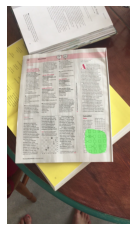

In [91]:
frames_processed = np.array(frames_processed)
ani = animate(frames_processed)
del frames_processed

In [92]:
ani.save('data/box_segmentation/video/IMG_3201_prediction.mp4')
del ani

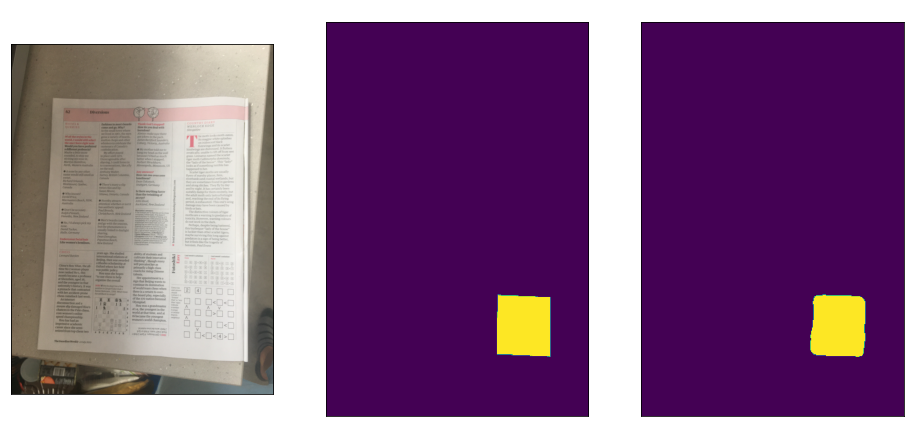

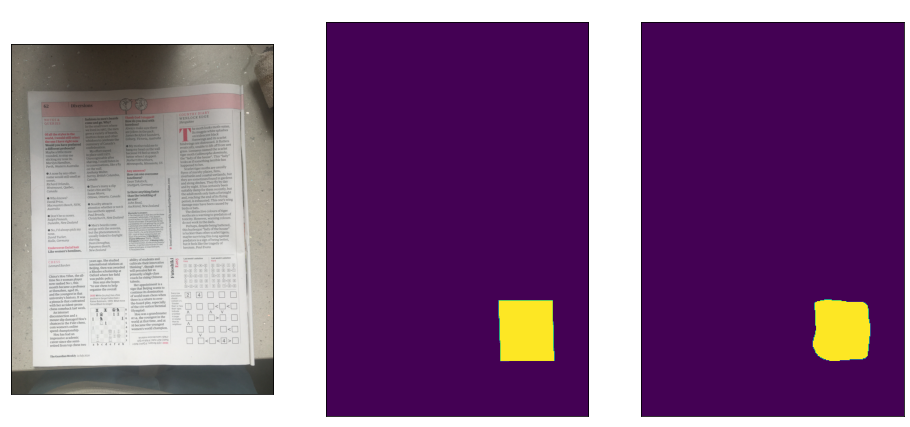

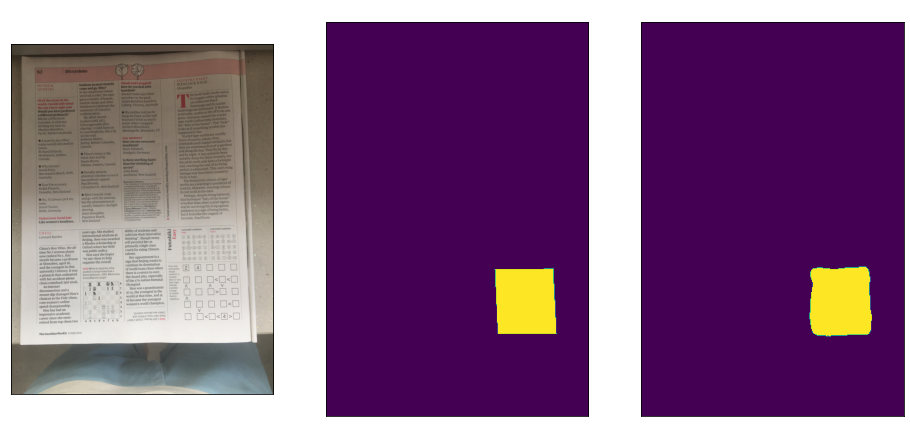

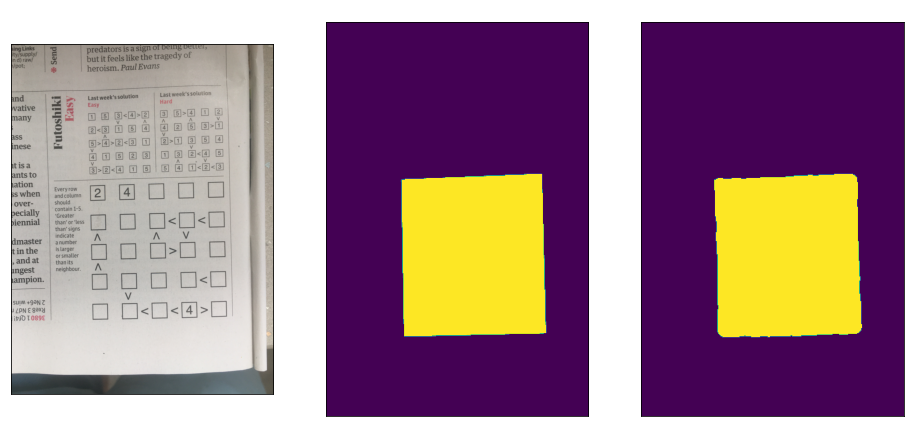

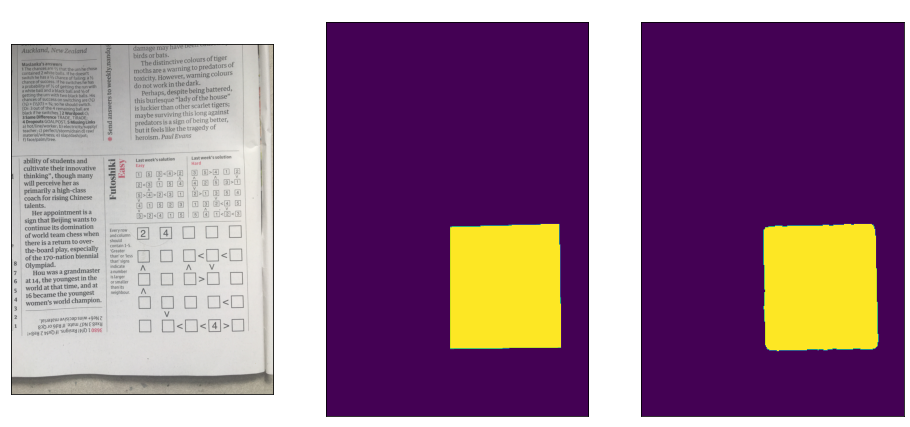

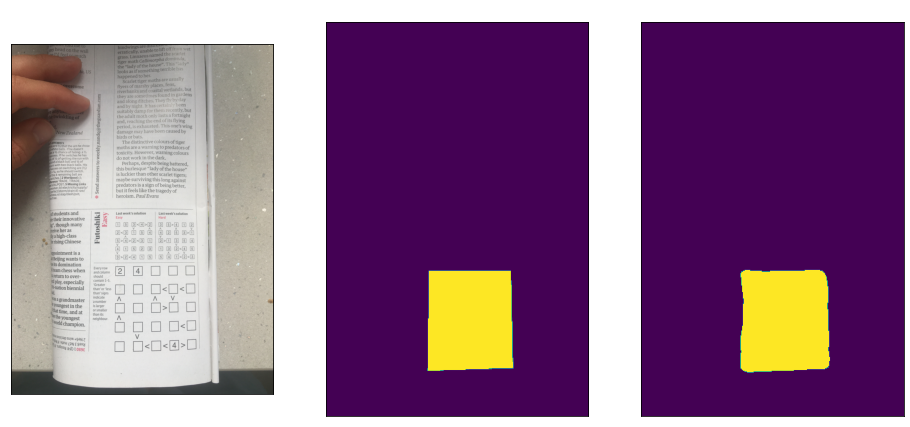

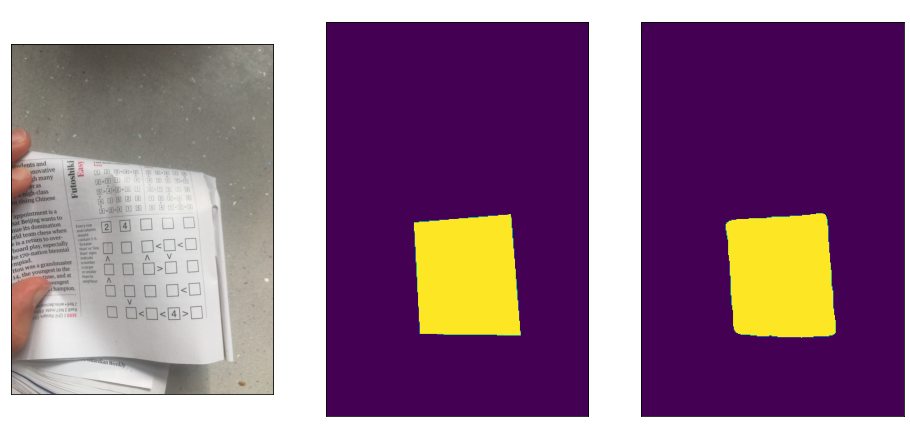

In [150]:
for i in range(len(test_dataset)):  
    torch.no_grad()
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = model_cpu.predict(x_tensor)
    pr_mask = pr_mask.squeeze().numpy().round()
        
    
    visualize(
        image=image_vis, 
        actual=gt_mask, 
        predicted=pr_mask
    )
    

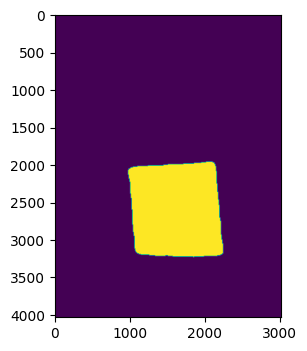

In [59]:
pr_mask_full = cv2.resize(pr_mask, (image_vis.shape[1], image_vis.shape[0]))
plt.imshow(pr_mask_full)

In [60]:
def mask_input(input_image, mask):
    mask = np.dstack([mask] * 3)
    mask = (mask == 1)
    #input_image = cv2.resize(input_image, (480, 320))
    return np.where(mask, input_image, 0)


In [61]:
masked_img = mask_input(image_vis, pr_mask_full)

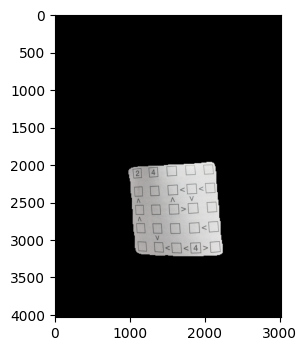

In [62]:
plt.imshow(masked_img)

In [63]:
imgray = cv2.cvtColor(masked_img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [64]:
# get largest contour, generate bounding rectangle of minimum area - including rotation
c = max(contours, key = cv2.contourArea)
rect = cv2.minAreaRect(c)
box = cv2.boxPoints(rect)
box = np.int0(box)

In [65]:
# get largest contour - no rotation
x,y,w,h = cv2.boundingRect(c)

In [66]:
cropped = masked_img[y:y+h, x:x+w]

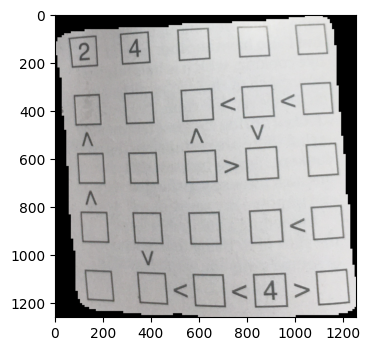

In [67]:
plt.imshow(cropped)

In [68]:
#img = cv2.drawContours(masked_img,[box],0,(0,0,255),50)

In [69]:
#img = cv2.rectangle(masked_img,(x,y),(x+w,y+h),(0,255,0),50)

In [70]:
def affine_trans(rect, src):
    """Peform an affine transformation based on theta of bounding rectangle."""
    
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D(center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, (src.shape[1], src.shape[0]))
    out = cv2.getRectSubPix(dst, size, center)
    return out

In [71]:
affine_img = affine_trans(rect, masked_img)

In [56]:
out = cv2.getRectSubPix(masked_img, size, center)

NameError: name 'size' is not defined

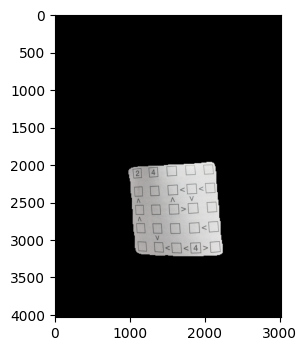

In [73]:
plt.imshow(masked_img)

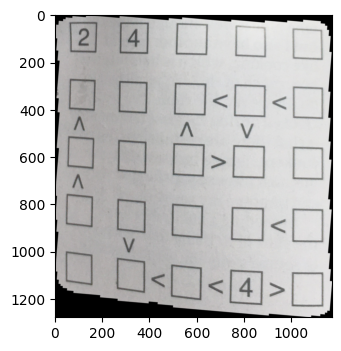

In [74]:
plt.imshow(affine_img)

In [83]:
from main.img_process import process_image

In [84]:
process_image(cropped, debug=True)

Processing contours...: 100%|██████████| 49/49 [00:00<00:00, 15941.74it/s]

Accepted contours 25


([array([[212, 211, 209, ..., 207, 200, 182],
         [213, 212, 209, ..., 206, 205, 194],
         [212, 211, 208, ..., 209, 209, 200],
         ...,
         [203, 209, 204, ..., 211, 212, 212],
         [202, 208, 205, ..., 180, 179, 175],
         [199, 208, 206, ..., 146, 144, 142]], dtype=uint8),
  array([[226, 225, 224, ..., 167, 156, 151],
         [222, 224, 226, ..., 166, 154, 149],
         [225, 228, 225, ..., 166, 155, 151],
         ...,
         [138, 134, 137, ..., 222, 226, 230],
         [140, 139, 164, ..., 223, 222, 223],
         [139, 141, 167, ..., 210, 209, 206]], dtype=uint8),
  array([[231, 229, 228, ..., 185, 174, 167],
         [231, 229, 226, ..., 190, 178, 177],
         [228, 229, 228, ..., 193, 180, 182],
         ...,
         [176, 189, 207, ..., 215, 217, 220],
         [176, 190, 204, ..., 214, 217, 216],
         [171, 194, 204, ..., 203, 201, 197]], dtype=uint8),
  array([[105, 107, 105, ..., 173, 150,  87],
         [141, 141, 141, ..., 169, 145,

In [134]:
type(affine_img)

numpy.ndarray

In [127]:
imgray = cv2.cvtColor(affine_img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [128]:
contours = sorted(contours,
                  key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * affine_img.shape[1])

In [129]:
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    _ = cv2.rectangle(affine_img,(x,y),(x+w,y+h),(0,255,0),10)

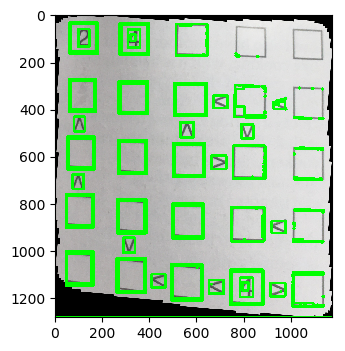

In [130]:
plt.imshow(affine_img)

In [130]:
d_mask = np.dstack([pr_mask] * 3)
d_mask = (d_mask == 1)

In [135]:
image_vis_res = cv2.resize(image_vis, (480, 480))

In [142]:
plt.imshow(np.where(d_mask, image_vis_res, 0))

array([[[ 29,  28,  23],
        [ 54,  49,  47],
        [ 81,  73,  73],
        ...,
        [132,  92,  47],
        [131,  91,  45],
        [129,  91,  43]],

       [[ 32,  31,  27],
        [ 69,  66,  63],
        [104,  98,  94],
        ...,
        [130,  93,  48],
        [130,  92,  46],
        [128,  90,  43]],

       [[ 27,  23,  20],
        [ 67,  62,  58],
        [105,  99,  92],
        ...,
        [126,  88,  43],
        [127,  91,  45],
        [127,  93,  45]],

       ...,

       [[ 25,  25,  23],
        [ 25,  25,  23],
        [ 26,  26,  24],
        ...,
        [ 19,  27,  30],
        [ 21,  27,  31],
        [ 22,  27,  31]],

       [[ 28,  30,  27],
        [ 27,  28,  25],
        [ 26,  27,  23],
        ...,
        [ 18,  26,  29],
        [ 17,  25,  28],
        [ 17,  25,  28]],

       [[ 26,  27,  22],
        [ 25,  26,  21],
        [ 24,  26,  20],
        ...,
        [ 18,  26,  29],
        [ 18,  26,  29],
        [ 17,  25,  28]]

In [125]:
(pr_mask==1)[:, :, 0]

IndexError: too many indices for array

In [105]:
image.shape, pr_mask.shape

((3, 480, 480), (480, 480))

In [101]:
pr_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [100]:
image_vis.shape

(4032, 3024, 3)

In [98]:
plt.imshow(image_vis[:, pr_mask==1])

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3024 but corresponding boolean dimension is 480

In [90]:
np.where()

array([[[ 0.2795616 ,  0.2795616 ,  0.26243687, ..., -0.3198048 ,
         -0.50817704, -0.4225533 ],
        [-0.59380084, -0.7136741 , -0.7479236 , ..., -0.45680282,
         -0.33692953, -0.5253018 ],
        [-0.8506721 , -0.9020464 , -0.9705454 , ..., -0.59380084,
         -0.59380084, -0.55955136],
        ...,
        [-1.9124069 , -1.9295317 , -1.9466563 , ..., -1.7754089 ,
         -1.8952821 , -1.9124069 ],
        [-2.0151553 , -1.8610326 , -1.9124069 , ..., -1.8781574 ,
         -1.9637811 , -1.9295317 ],
        [-1.8781574 , -1.9466563 , -1.9466563 , ..., -1.9124069 ,
         -1.8952821 , -1.8781574 ]],

       [[ 0.4327731 ,  0.5028011 ,  0.5553221 , ..., -0.12745099,
         -0.390056  , -0.320028  ],
        [-0.63515407, -0.61764705, -0.6526611 , ..., -0.320028  ,
         -0.214986  , -0.390056  ],
        [-0.7927171 , -0.8627451 , -0.9327731 , ..., -0.46008402,
         -0.46008402, -0.42507002],
        ...,
        [-1.7556022 , -1.8081232 , -1.8256303 , ..., -

In [89]:
pr_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)